## WHOLE IMAGE TESTING AND mIOU Calculation

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

from torchvision import transforms, utils, models
import torchvision.transforms.functional as TF

import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import os
import imageio

from PIL import Image

import skimage.external.tifffile as tifffile
import cv2
import glob

import os,sys,inspect
ConvCRF_dir = '../ConvCRF'
sys.path.insert(0,ConvCRF_dir)
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
# resnet = models.resnet34(pretrained=True)
# layers = list(resnet.children())
# from model.architecture import ResUNet
# model = ResUNet(layers, 2)

In [36]:
densenet = models.inception_v3(pretrained=True)

In [37]:
densenet.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [28]:
from torchsummary import summary

In [38]:
summary(densenet, (3,480,480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 239, 239]             864
       BatchNorm2d-2         [-1, 32, 239, 239]              64
       BasicConv2d-3         [-1, 32, 239, 239]               0
            Conv2d-4         [-1, 32, 237, 237]           9,216
       BatchNorm2d-5         [-1, 32, 237, 237]              64
       BasicConv2d-6         [-1, 32, 237, 237]               0
            Conv2d-7         [-1, 64, 237, 237]          18,432
       BatchNorm2d-8         [-1, 64, 237, 237]             128
       BasicConv2d-9         [-1, 64, 237, 237]               0
           Conv2d-10         [-1, 80, 118, 118]           5,120
      BatchNorm2d-11         [-1, 80, 118, 118]             160
      BasicConv2d-12         [-1, 80, 118, 118]               0
           Conv2d-13        [-1, 192, 116, 116]         138,240
      BatchNorm2d-14        [-1, 192, 1

In [2]:
"PLEASE SET THESE VALUES"

patch_size = 480
overlap = 1/2 # Greater the denominator, Greater the overlap
black_patches = False # Include black patches?
floe_only = True # Include only patches that contain a floe?

In [3]:
if(patch_size * overlap).is_integer():
    print(f"Overlap of {overlap} is accepted")
    step = int(patch_size * overlap)

else:
    print(f"Overlap of {overlap} is NOT ACCEPTED, Please input something else like 1/2, 1/4, 1/6, 1/8, 1/12")

Overlap of 0.5 is accepted


In [4]:
"""
TEST IMAGES
im_rsat2_ar_20110615105638_00079057_l
im_rsat2_ar_20140615112940_00115653_l

VAL IMAGES
im_rsat2_ar_20120508112949_00091906_l
im_rsat2_ar_20120606104418_00092688_l
"""

'\nTEST IMAGES\nim_rsat2_ar_20110615105638_00079057_l\nim_rsat2_ar_20140615112940_00115653_l\n\nVAL IMAGES\nim_rsat2_ar_20120508112949_00091906_l\nim_rsat2_ar_20120606104418_00092688_l\n'

In [16]:
img_name = 'im_rsat2_ar_20120606104418_00092688_l.tif'
mode = 'val'

image = tifffile.imread('/home/muzik999/MASc/iceFloe/floes/data/images/'+mode+'/' + img_name)
mask = plt.imread('/home/muzik999/MASc/iceFloe/floes/data/annotation_masks/' + img_name[:-4] + '.png')[:,:,0]
mask = np.ceil(mask).astype(np.uint8)

img_save_dir = '/home/muzik999/MASc/iceFloe/floes/data/'+mode+'/whole_images/192/img/'
mask_save_dir = '/home/muzik999/MASc/iceFloe/floes/data/'+mode+'/whole_images/192/mask/'

In [17]:
img_x, img_y = image.shape

In [18]:
left = 0
top = 0
right = patch_size - (img_y % patch_size)
bottom = patch_size - (img_x % patch_size)

In [19]:
image_padded = TF.pad(TF.to_pil_image(image), (left, top, right, bottom))
_, img_go_x, img_go_y = TF.to_tensor(image_padded).shape

mask_padded = TF.pad(TF.to_pil_image(mask), (left, top, right, bottom))

In [21]:
# from torchvision.models.segmentation.deeplabv3 import DeepLabHead
# model1 = models.segmentation.deeplabv3_resnet101(pretrained=True)
# model1.classifier = DeepLabHead(2048, 1)

In [37]:
# resnet = models.resnet34(pretrained=True)
# layers = list(resnet.children())
# from model.architecture import ResUNet

In [38]:
# """FCN RESNET101"""

# from torchvision.models.segmentation.fcn import FCNHead
# model = models.segmentation.fcn_resnet101(pretrained=True)
# model.classifier = FCNHead(2048, 1)

In [39]:
# from model.architecture import UNet
# model1 = UNet(1)

In [8]:
path = '/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_LOSS/dice_only/2_480_DICE_ONLYmodel1RESUNET_2000iter_NEW_DATA.mdl'
model1 = torch.load(path)
# model1 = torch.load('../model/weights/UNET_CRF/NEW/8_192_model1DLv3_1500iter_NEW_DATA.mdl')

In [9]:
from tools.crf_conf import default_conf as conf
from convcrf import convcrf

conf['filter_size'] = 1
conf['blur'] = 0
conf['trainable'] = False
conf['trainable_bias'] = False

In [10]:
model2 = convcrf.GaussCRF(conf=conf, shape=(patch_size,patch_size), nclasses=2)
path2 = '/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_LOSS/dice_only/2_480_DICE_ONLYmodel2RESUNET_2000iter_NEW_DATA_FT.mdl'
model2 = torch.load(path2)
model2.cuda()

for param in list(model2.parameters()):
    param.requires_grad = False

In [20]:
model1.cuda()
model1.eval()
with torch.no_grad():
    pred1_list = []
    pred2_list = []
    mask_list = []
    
    image_mask = torch.zeros((img_go_x+step, img_go_y+step))

    for i in range(0,img_go_x, step):
        for j in range(0,img_go_y, step):

            patch_img = TF.crop(image_padded, i,j,patch_size,patch_size)
            patch_img_tensor = TF.to_tensor(patch_img) * 255
            img_patch_save = np.array(torch.stack((patch_img_tensor.squeeze(), patch_img_tensor.squeeze(), patch_img_tensor.squeeze()), dim = 0)).astype(np.uint8)

            patch_mask = TF.crop(mask_padded, i,j,patch_size,patch_size)
            patch_mask_tensor = TF.to_tensor(patch_mask) * 255
            mask_patch_save = np.array(patch_mask_tensor.squeeze())
            
            img_tensor = torch.tensor(img_patch_save).unsqueeze(0)
            img_tensor = img_tensor.to('cuda', dtype=torch.float)
            
            pred1 = model1(img_tensor)
            pred2 = model2(unary = torch.sigmoid(pred1), img = img_tensor)
            pred1_list.append(pred1.cpu().detach())
            
            mask_list.append(mask)
            
            image_mask[i: i+patch_size, j: j+patch_size] += (torch.sigmoid(pred2[0,1,:,:].squeeze())>0.5).cpu().detach() 
            # [0,1,:,:] for RESUNET and ['out'][0,0,:,:] for DLV3 and [0,0,:,:] for normal UNET

In [12]:
from sklearn.metrics import confusion_matrix, f1_score

def compute_mPA(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    
    mPA = 0.5 * (tn/(tn+fp) + tp/(tp+fn))
    return mPA

def compute_miou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    
    mIOU = np.mean(IoU)
    mPA = compute_mPA(current)
    
    return mIOU, mPA

def compute_f1_score(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    
    f1 = f1_score(y_true = y_true, y_pred = y_pred)
    
    return f1

In [21]:
mask_GT = mask.astype('float')
# mask_GT[mask_GT == 0] = 'nan'

a,b = mask_GT.shape

mask_PRED = np.array((image_mask[:a, :b]>2)).astype('float')
mask_PRED[mask_PRED == 0] = -1

mask_OL = (mask_GT == mask_PRED.astype('float')).astype('float')

mask_GT[mask_GT == 0] = 'nan'
mask_PRED[mask_PRED == -1] = 'nan'
mask_OL[mask_OL == 0] = 'nan'

In [22]:
image_plt = plt.imread('/home/muzik999/MASc/iceFloe/floes/data/images/raw/' + img_name)
folder = '/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_PATCH/LOSS_EXP/'

In [23]:
plt.figure(figsize=(50,50))
plt.title(img_name + '             Pink = "TP", Yellow = "FP", Blue = "FN"', fontdict={'fontsize': 50})
plt.imshow(image_plt, cmap='gray')
plt.imshow(mask_GT, cmap='brg', alpha=0.5)
plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

plt.savefig(folder + 'IMG_ALL_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Blue = "Ground Truth"', fontdict={'fontsize': 50})
plt.imshow(image_plt, cmap='gray')
plt.imshow(mask_GT, cmap='brg', alpha=0.5)
# plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
# plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

plt.savefig(folder + 'IMG_GT_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Yellow = "Prediction"', fontdict={'fontsize': 50})
plt.imshow(image_plt, cmap='gray')
# plt.imshow(mask_GT, cmap='brg', alpha=0.5)
plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
# plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

plt.savefig(folder + 'IMG_PRED_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Pink = "Overlap"', fontdict={'fontsize': 50})
plt.imshow(image_plt, cmap='gray')
# plt.imshow(mask_GT, cmap='brg', alpha=0.5)
# plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

plt.savefig(folder + 'IMG_OL_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Pink = "TP", Yellow = "FP", Blue = "FN"', fontdict={'fontsize': 50})
plt.imshow(np.zeros((a,b)), cmap='gray')
plt.imshow(mask_GT, cmap='brg', alpha=1)
plt.imshow(mask_PRED, cmap='autumn_r', alpha=1)
plt.imshow(mask_OL, cmap='cool_r', alpha=1)

plt.savefig(folder + 'MASK_ALL_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Blue = "Ground Truth"', fontdict={'fontsize': 50})
plt.imshow(np.zeros((a,b)), cmap='gray')
plt.imshow(mask_GT, cmap='brg', alpha=1)

plt.savefig(folder + 'MASK_GT_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Yellow = "Prediction"', fontdict={'fontsize': 50})
plt.imshow(np.zeros((a,b)), cmap='gray')
plt.imshow(mask_PRED, cmap='autumn_r', alpha=1)

plt.savefig(folder + 'MASK_PRED_' + img_name[:-4] + '.png')
plt.close()

plt.figure(figsize=(50,50))
plt.title(img_name + '             Pink = "Overlap"', fontdict={'fontsize': 50})
plt.imshow(np.zeros((a,b)), cmap='gray')
plt.imshow(mask_OL, cmap='cool_r', alpha=1)

plt.savefig(folder + 'MASK_OL_' + img_name[:-4] + '.png')
plt.close()

In [14]:
x,y = mask.shape
image_mask_96_1 = image_mask[:x, :y]
mask_96_1 = mask

In [20]:
x,y = mask.shape
image_mask_96_2 = image_mask[:x, :y]
mask_96_2 = mask

In [21]:
pred = torch.cat(((image_mask_96_1>2).flatten(),(image_mask_96_2>2).flatten())).flatten()
mskk = np.concatenate((mask_96_1.flatten(),mask_96_2.flatten())).flatten()
pred.shape == mskk.shape

True

In [22]:
iou1, mPA1 = compute_miou(y_pred = image_mask_96_1>2, y_true = mask_96_1)
f1_1 = compute_f1_score(y_pred = image_mask_96_1>2, y_true = mask_96_1)

In [23]:
iou2, mPA2 = compute_miou(y_pred = image_mask_96_2>2, y_true = mask_96_2)
f1_2 = compute_f1_score(y_pred = image_mask_96_2>2, y_true = mask_96_2)

In [24]:
miou, mPA = compute_miou(y_pred = pred, y_true = mskk)
m_f1 = compute_f1_score(y_pred = pred, y_true = mskk)

In [25]:
print(f'Image 1 \nIoU = {iou1} \nF1 = {f1_1} \nmPA = {mPA1}')

Image 1 
IoU = 0.7475861867632604 
F1 = 0.6719322403803685 
mPA = 0.8033860362170011


In [26]:
print(f'Image 2 \nIoU = {iou2} \nF1 = {f1_2} \nmPA = {mPA2}')

Image 2 
IoU = 0.75401129547812 
F1 = 0.6756397915491088 
mPA = 0.8729569062208238


In [27]:
print(f'Image Combined \nmIoU = {miou} \nF1 = {m_f1} \nmPA = {mPA}')

Image Combined 
mIoU = 0.7507173290840496 
F1 = 0.672816275489812 
mPA = 0.8181013724263646


In [27]:
from torchsummary import summary
summary(model1, (3,480,480), )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 480, 480]           1,792
       BatchNorm2d-2         [-1, 64, 480, 480]             128
              ReLU-3         [-1, 64, 480, 480]               0
            Conv2d-4         [-1, 64, 480, 480]          36,928
       BatchNorm2d-5         [-1, 64, 480, 480]             128
              ReLU-6         [-1, 64, 480, 480]               0
            Conv2d-7         [-1, 64, 240, 240]           9,408
       BatchNorm2d-8         [-1, 64, 240, 240]             128
              ReLU-9         [-1, 64, 240, 240]               0
        MaxPool2d-10         [-1, 64, 120, 120]               0
           Conv2d-11         [-1, 64, 120, 120]          36,864
      BatchNorm2d-12         [-1, 64, 120, 120]             128
             ReLU-13         [-1, 64, 120, 120]               0
           Conv2d-14         [-1, 64, 1

In [ ]:
def plot_ALL():
    plt.figure(figsize=(50,50))
    plt.title(img_name + '             Pink = "TP", Yellow = "FP", Blue = "FN"', fontdict={'fontsize': 50})
    plt.imshow(image_plt, cmap='gray')
    plt.imshow(mask_GT, cmap='brg', alpha=0.5)
    plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
    plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

    plt.savefig('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_BACKBONE/' + 'ALL_' + img_name[:-4] + '.png')
    plt.close()

In [ ]:
def plot_GT():
    plt.figure(figsize=(50,50))
    plt.title(img_name + '             Blue = "Ground Truth"', fontdict={'fontsize': 50})
    plt.imshow(image_plt, cmap='gray')
    plt.imshow(mask_GT, cmap='brg', alpha=0.5)
    # plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
    # plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

    plt.savefig('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_BACKBONE/' + 'GT_' + img_name[:-4] + '.png')
    plt.close()

In [ ]:
def plot_PRED():
    plt.figure(figsize=(50,50))
    plt.title(img_name + '             Yellow = "Prediction"', fontdict={'fontsize': 50})
    plt.imshow(image_plt, cmap='gray')
    # plt.imshow(mask_GT, cmap='brg', alpha=0.5)
    plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
    # plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

    plt.savefig('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_BACKBONE/' + 'PRED_' + img_name[:-4] + '.png')
    plt.close()

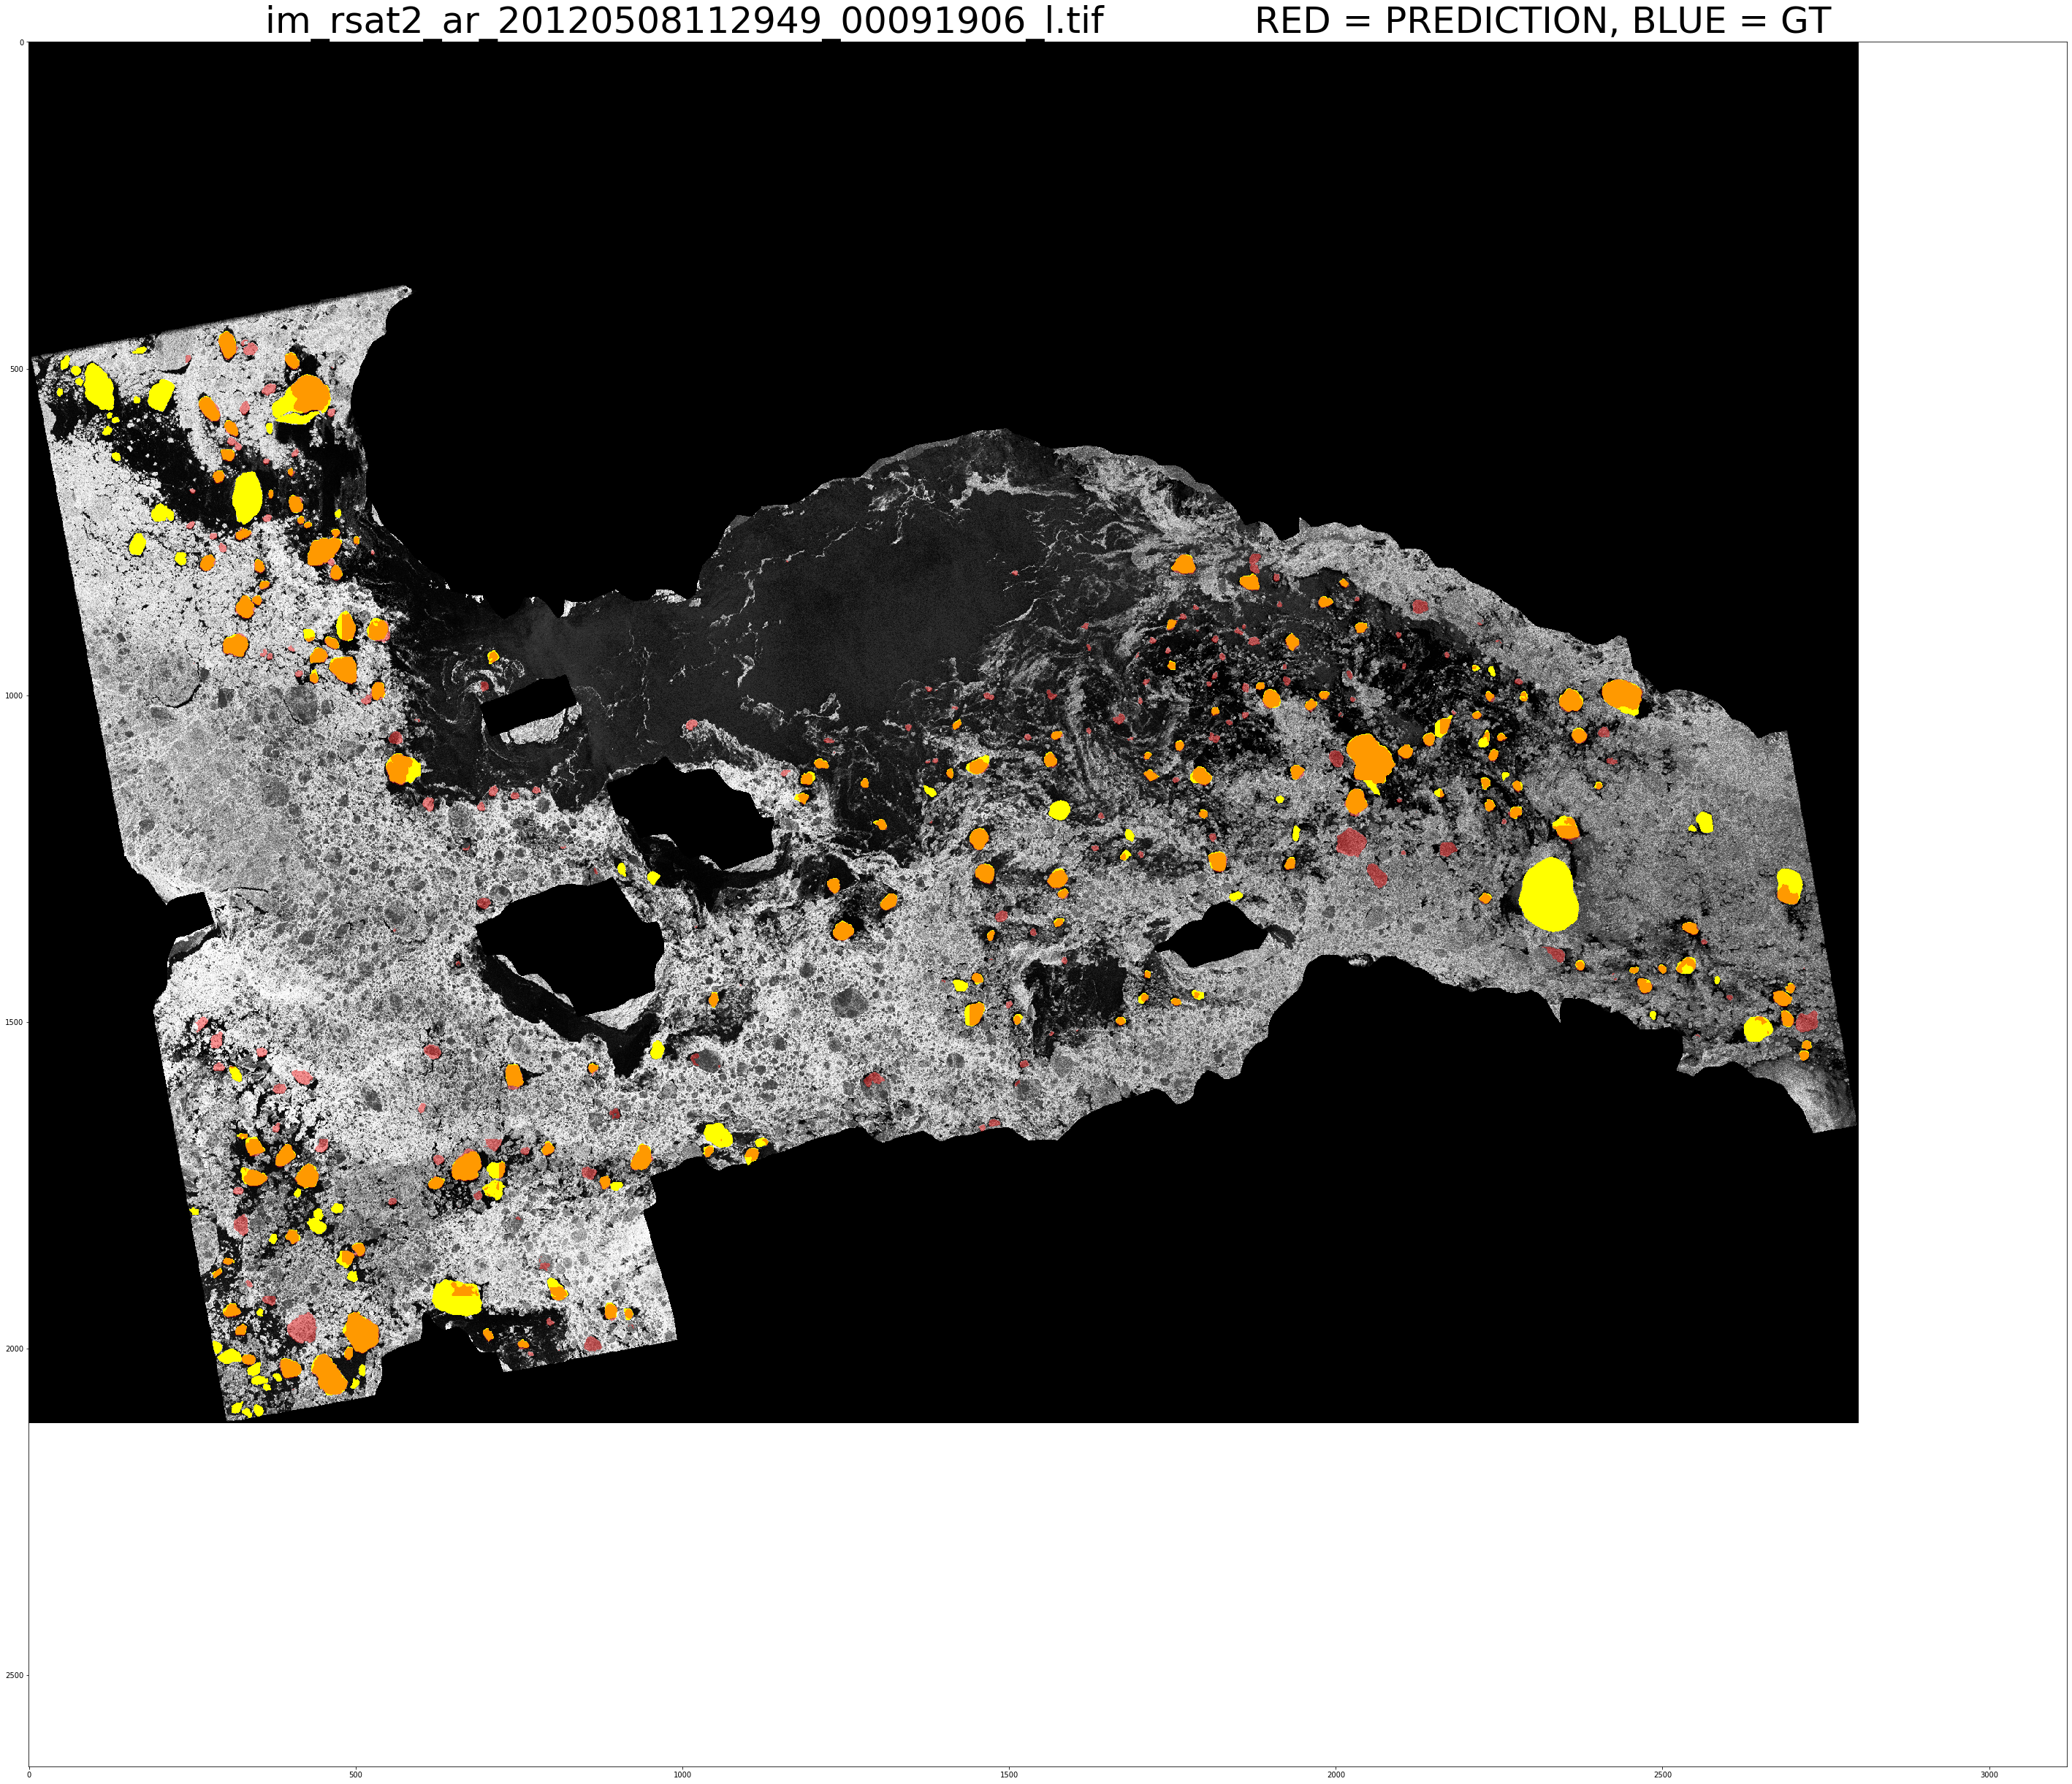

In [125]:
def plot_OL():
    plt.figure(figsize=(50,50))
    plt.title(img_name + '             Pink = "Overlap"', fontdict={'fontsize': 50})
    plt.imshow(image_plt, cmap='gray')
    # plt.imshow(mask_GT, cmap='brg', alpha=0.5)
    # plt.imshow(mask_PRED, cmap='autumn_r', alpha=0.7)
    plt.imshow(mask_OL, cmap='cool_r', alpha=0.5)

    plt.savefig('/home/muzik999/MASc/iceFloe/floes/model/weights/UNET_CRF/NEW/experiment_BACKBONE/' + 'OL_' + img_name[:-4] + '.png')
    plt.close()